# CECAM tutorial - Unsupervised learning: clustering

We will present two examples of clustering, the first applied to a Molecular Dynamics trajectory of aspirin in order to distinguish different conformers, the second one to a set of different molecules in order to classify them based on geometrical properties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Function for k-means clustering

If you are interested in the k-means clustering algorithm, you can look at this plain function kmeans (otherwise just use the one by scikit-learn sklearn.cluster.KMeans)

kmeans function

inputs:
- data, numpy array (n. of patterns) x (n. of features)
- k, the n. of clusters you select

outputs:
- z, the resulting labels of each pattern into a cluster
- icount, the n. of iterations

algorithm:
- 1. randomly pick k centers (or centroids) among all the data points
- 2. assign each data point to its nearest center; in this way, you have got a first splitting into clusters
- 3. refine this splitting: for each cluster, compute its new center as the average point of all the data points in the cluster
- 4. repeat 3, 4 until convergence (when the new assignment into centers coincides with the previous one)

In [2]:
def kmeans(data, k):

    from scipy.spatial import distance_matrix

    npatt, nfeat = data.shape

    # 1. randomly pick k centers
    centroids = np.zeros((k, nfeat))
    inds = np.random.choice(npatt, k, replace=False)
    for i in range(k):
        centroids[i, :] = data[inds[i], :]

    # 2. assign each point to its nearest center
    distances = distance_matrix(data, centroids)
    z = np.zeros(npatt) # column index of the min distance per row
    zold = np.zeros(npatt)
    z = np.argmin(distances, axis=1)

    icount = 0
    while np.any(np.not_equal(z, zold)):
        zold = z
        # 3. update the k cluster centroids based on the assigned cluster membership
        for i in range(k):
            inds = np.where(z == i)
            centroids[i, :] = np.mean(data[inds, :], axis=1)

        distances = distance_matrix(data, centroids)
        z = np.argmin(distances, axis=1)
        icount += 1

    return z, icount

## Example n.1: Molecular Dynamics trajectory of aspirin

In [3]:
from ase import Atoms

Import the data, in this case an npz file of a molecular dynamics trajectory for aspirin. The full trajectory can be downloaded from http://quantum-machine.org/gdml/data/npz/ (filename **md17_aspirin.npz**). Download it and put in folder **data** with same name md17_aspirin.npz. Otherwise, just use reduced subset of trajectory **data/md17_aspirin_10000.npz**.

In [4]:
data = np.load("../data/md17_aspirin_10000.npz")
# data = np.load("../data/md17_aspirin.npz")
step = 10

# Coordinates for each timestep
R = data['R'][::step]
n_steps, n_atoms, _ = R.shape
print(f'Total of {R.shape[0]} steps for {n_atoms} atoms')
z = data['z'] # atomic numbers for each atom
E = data['E'][::step]-np.mean(data['E'][::step]) # for later use

Total of 1000 steps for 21 atoms


We will perform clustering on the geometrical information provided in the dataset. We are only given the atomic coordinates at each time step like so: (n_steps, n_atoms, 3). 

However, we have to encode the geometry in a way that is rotational and translationally invariant. The easiest way to accomplish this is by using all pairwise distances between our atoms at each timestep.

In [5]:
# Pairwise distances could easily be computed using
# our own custom functions, but we'll use ASE here

# Create a list of ASE atom objects using the
# coordinates and atomic numbers in the dataset
atoms = [Atoms(positions=r, numbers=z) for r in R]

# ase gives a full distance matrix, but we only need
# every pair once (and ignore the diagonal).
# Hence, we will index only the upper/lower triangle
triangle_indices = np.tril_indices(n_atoms, k=-1)

# Generate distances
distances = [x.get_all_distances()[triangle_indices] for x in atoms]
distances = np.array(distances)
print(f"Distance descriptor generated of shape: {distances.shape}")

Distance descriptor generated of shape: (1000, 210)


We are now ready to cluster our data. Choosing the number of clusters to create is an art in and of itself: for the purpose of this tutorial, we will use a metric called the silhouette score to point us in the right direction. 

In short, it is a score telling us the "quality" of clusters given a descriptor. This means that we first need to generate clusters for a given number (for us from 2-10) and then we settle on the one with the best score.

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

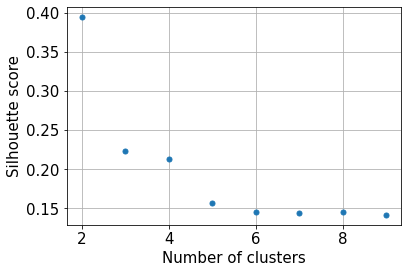

In [7]:
n_clusters_list = np.arange(2,10)
sil_scores = [] # where we'll save the scores
labels_list = [] # where we'll save the labels

for n_clusters in n_clusters_list:
    km = KMeans(n_clusters=n_clusters)
    labels = km.fit_predict(distances)
    score = silhouette_score(distances, labels)

    sil_scores.append(score)
    labels_list.append(labels)

plt.figure()

plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10

plt.ylabel("Silhouette score")
plt.xlabel("Number of clusters")
plt.plot(n_clusters_list, sil_scores,'.')
plt.grid()

In our case, n_clusters = 2 seems to be the "best" one. Note that the notion of "best" clusters is vague and highly dependent on the specific application. In most cases, knowledge of the system at hand should be applied to determine the clustering quality.

We can now analyse our clusters: since the dataset provided energies as well as geometric information, we can see if the energy distribution varies from one cluster to the other.

(Note: we will continue with 2 clusters, as indicated by the silhouette score, but the code below is written generally. Change the variable n_clusters to switch to a higher number.)

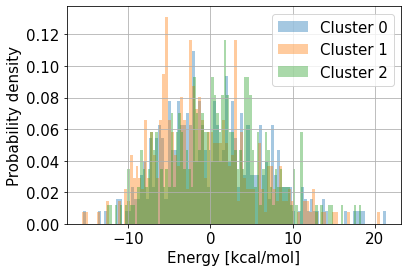

In [8]:
n_clusters = 3
labels = labels_list[n_clusters-2]

# For each cluster, create an energy subset and plot the distribution
plt.figure()
plt.rcParams['font.size'] = 15

for i in range(n_clusters):
    cluster_idxs = np.argwhere(labels == i).flatten()
    ei = E[cluster_idxs]
    plt.hist(ei, bins=100, alpha=0.4, density=True, label=f'Cluster {i}')

plt.legend()
plt.ylabel("Probability density")
plt.xlabel("Energy [kcal/mol]")
plt.grid()


Overall, there is a very slight shift in energy distribution from cluster to cluster. However, the cluster label of a point is not a strong indicator for its energy: this makes sense, as predicting the potential energy surface from the geometry of a molecule is a highly complex task for which significantly more elaborate (and supervised) methods are required.

That being said, the two clusters have in fact split the dataset into meaningfully different parts: to prove this, we will look at the dihedral angle between the benzene ring and the carboxylic group attached to it. This is one of the major ways this molecule can rotate and it takes up various values throughout the reference trajectory.

In [9]:
from ase.visualize import view

# indices of atom1,2,3,4 forming the aforementioned dihedral

frame_indices = []
for i in range(n_clusters):
    frame_indices.append(np.where(labels == i)[0][0]) # first frame in the i-th cluster

i=2
view(atoms[frame_indices[i]], viewer='x3d')
#view(atoms[index_b], viewer='x3d')


Text(0, 0.5, 'Prob. density')

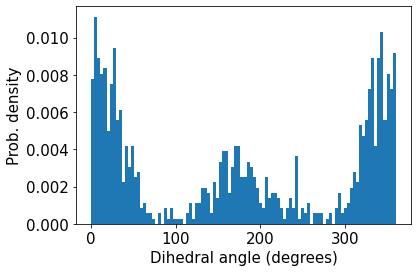

In [10]:
dihedral_indices = [6, 5, 10, 7]
dihedrals = np.array([x.get_dihedral(*dihedral_indices) for x in atoms])

plt.hist(dihedrals, bins=100, density=True)
plt.xlabel("Dihedral angle (degrees)")
plt.ylabel("Prob. density")

Throughout the entire trajectory, the dihedral angle spends most of its time around 360 and 180 degrees, as indicated by the well-defined peaks above. We can now plot the same dihedral angle but for each cluster seperately.

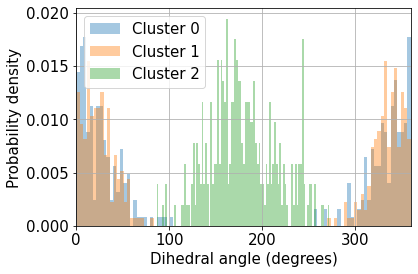

relative populations of the clusters:  [0.346 0.377 0.277]


In [11]:
# For each cluster, create a dihedral subset and plot the distribution
populations = []

plt.figure()
plt.rcParams['font.size'] = 15

for i in range(n_clusters):
    cluster_idxs = np.argwhere(labels == i).flatten()
    populations.append(len(cluster_idxs))
    dih = dihedrals[cluster_idxs]
    plt.hist(dih, bins=100, alpha=0.4, density=True, label=f'Cluster {i}')

plt.xlabel("Dihedral angle (degrees)")
plt.ylabel("Probability density")
plt.xlim([0, 360])
plt.legend()
plt.grid()
plt.show()

print('relative populations of the clusters: ', populations/np.sum(populations))

With 2 clusters, we see a very good separation between the two dihedral peaks for each cluster. That is, this clearly shows that different clusters do represent qualitatively different geometries. For a higher number of clusters, there is a greater overlap for this particular dihedral (however, other geometrical properties not shown here would be different). 

## Example n.2: distinguish different groups of molecules

Dataset: http://quantum-machine.org/datasets/#qm7

The dataset is composed of three multidimensional arrays X (7165 x 23 x 23), T (7165) and P (5 x 1433) representing the inputs (Coulomb matrices), the labels (atomization energies) and the splits for cross-validation, respectively. The dataset also contain two additional multidimensional arrays Z (7165) and R (7165 x 3) representing the atomic charge and the cartesian coordinate of each atom in the molecules.

We will perform clustering on the geometrical properties of the different molecules, and on the atomic numbers of their atoms. To this aim, let's use the independent elements of the (symmetric) Coulomb matrix.

In [12]:
import scipy.io
dataset = scipy.io.loadmat('../data/qm7.mat')

To count how many C (O) atoms there are in each molecule

In [13]:
n_C_atoms = np.count_nonzero(dataset['Z'] == 6, axis=1)
n_O_atoms = np.count_nonzero(dataset['Z'] == 8, axis=1)


Before clustering, let's select the molecules with fixed n. of atoms. Then, for each set of molecules with same n. of atoms, do clustering. Finally, to evaluate the goodness of your clustering, you can look at the atomization energies

the n. of atoms in the molecule is from 4 to 23


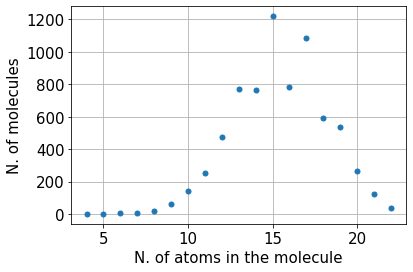

In [14]:
nonzeros = np.count_nonzero(dataset['Z'], axis=1)
print('the n. of atoms in the molecule is from %s to %s' % (np.min(nonzeros), np.max(nonzeros)))

lengths = []
for n_atoms in range(np.min(nonzeros), np.max(nonzeros)):
    lengths.append(len(dataset['Z'][np.where(nonzeros == n_atoms)]))

plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10

plt.plot(np.arange(np.min(nonzeros), np.max(nonzeros)), lengths, '.')
#plt.xticks(np.arange(np.min(nonzeros),np.max(nonzeros)))

plt.ylabel('N. of molecules')
plt.xlabel('N. of atoms in the molecule')
#plt.title('molecules per n. of atoms')
plt.grid()
plt.show()

Select the n. of atoms

In [15]:
n_atoms = 15

In [16]:
energies = dataset['T'][0][np.where(nonzeros == n_atoms)]
data = dataset['X'][np.where(nonzeros == n_atoms)]

coulomb = []
diagonal = []

# features: coulomb matrix, independent elements
for i_mol in range(len(data)):
    coulomb.append([])
    for i in range(n_atoms):
        for j in range(i+1):
            coulomb[i_mol].append(data[i_mol, i, j])
    diagonal.append(np.sum(np.diag(data[i_mol])))

    #coulomb.append(data[i_mol,:n_atoms,:n_atoms].flatten())

coulomb = np.array(coulomb)
print(coulomb.shape)

(1219, 120)


### Clustering


k-means algorithm requires to preliminarly fix the n. of clusters; usually, this information is a desired result of the clustering procedure, so you can proceed as above (previous example), selecting different number of clusters and evaluating the silhouette score

In [17]:
# here you can use the above k-means algorithm
#z_kmeans,icount=kmeans(coulomb,n_clusters)

# or simply the sci-kit learn one
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores_kmeans = []
labels_kmeans = []
ks_kmeans = np.arange(2,21)

for n_clusters in ks_kmeans:
    clustering = KMeans(n_clusters).fit(coulomb)
    labels_kmeans.append(clustering.labels_)
    scores_kmeans.append(silhouette_score(coulomb, labels_kmeans[-1]))


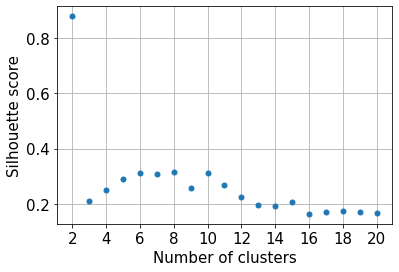

In [19]:
plt.figure()

plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10

plt.ylabel("Silhouette score")
plt.xlabel("Number of clusters")
plt.plot(ks_kmeans,scores_kmeans, '.')
plt.xticks(ks_kmeans[::2])
plt.grid()


Alternatively, you can use the DB-SCAN algorithm, which does not require to fix the n. of clusters. You can also compare the results provided by the two methods.

Unclassified patterns are marked by -1, so you can evaluate the goodness of the clustering by looking at the resulting labels

In [20]:
from sklearn.cluster import DBSCAN

scores_DBSCAN = []
labels_DBSCAN = []
ks_DBSCAN = []
epss = np.arange(5,85,5)


for eps in epss:
    clustering = DBSCAN(eps=eps, min_samples=3).fit(coulomb)
    labels_DBSCAN.append(clustering.labels_)
    scores_DBSCAN.append(silhouette_score(coulomb, labels_DBSCAN[-1]))
    ks_DBSCAN.append(np.max(labels_DBSCAN[-1]))


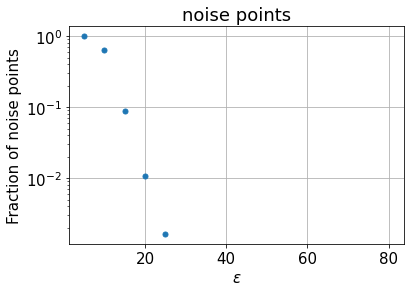

In [21]:
noises = []
for i in range(len(labels_DBSCAN)):
    noises.append(np.count_nonzero(labels_DBSCAN[i] == -1))

plt.title('noise points')
plt.plot(epss, np.array(noises)/len(labels_DBSCAN[i]), '.')
plt.yscale('log')
plt.ylabel('Fraction of noise points')
plt.xlabel(r'$\epsilon$')
plt.grid()
plt.show()

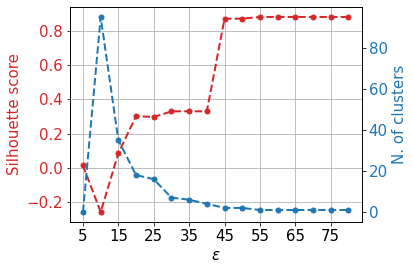

In [22]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r"$\epsilon$")
ax1.set_ylabel('Silhouette score', color=color)
ax1.plot(epss, scores_DBSCAN, '.--', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(epss[::2])
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('N. of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(epss, ks_DBSCAN, '.--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yscale('log')
#plt.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Results

coordinates for the 2d plot: sum of the off-diagonal elements of coulomb matrix (resuming the employed information) and atomization energy (new information)

In [23]:
sum_coulomb = np.sum(coulomb, axis=1)

k-means, k = 2

Text(0, 0.5, 'Energy [kcal/mol]')

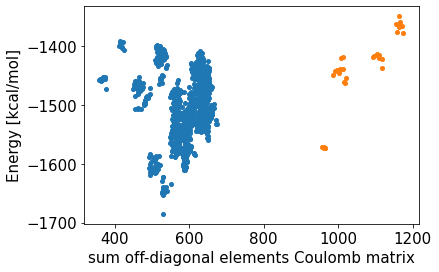

In [24]:
k = 2
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linewidth'] = 0.5

plt.figure()
#plt.title('k-means clustering (%s clusters)' % (np.max(labels)+1))
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.', label=i)

#plt.xlabel('Molecule index in the dataset')
#plt.xlabel('sum of diagonal of Coulomb matrix')
plt.xlabel('sum off-diagonal elements Coulomb matrix')
plt.ylabel('Energy [kcal/mol]')

comparison of the two algorithms (k-means at k=8, DB-SCAN at epsilon=20: similar Silhouette score)

Silhouette score:  0.31561005


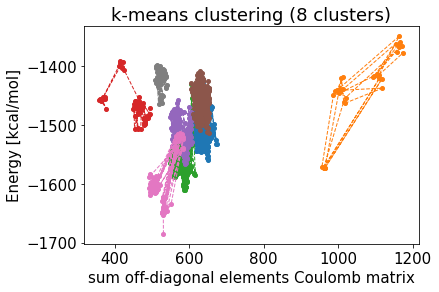

In [25]:
k = 8
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]
print('Silhouette score: ', scores_kmeans[index])

plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linewidth'] = 1

plt.figure()
plt.title('k-means clustering (%s clusters)' % (np.max(labels)+1))
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.--', label=i)

#plt.xlabel('Molecule index in the dataset')
#plt.xlabel('sum of diagonal of Coulomb matrix')
plt.xlabel('sum off-diagonal elements Coulomb matrix')
plt.ylabel('Energy [kcal/mol]')
plt.show()

Silhouette score:  0.30229318


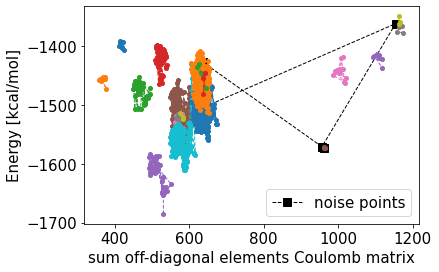

In [26]:
epsilon = 20
index = np.where(epss == epsilon)[0][0]
labels = labels_DBSCAN[index]
print('Silhouette score: ', scores_DBSCAN[index])

plt.figure()
#plt.title('DB-SCAN clustering (%s clusters)' % (np.max(labels)+1))
plt.plot(sum_coulomb[labels == -1], energies[labels == -1], 's--k', label='noise points')
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.--')

#plt.xlabel('Molecule index in the dataset')
#plt.xlabel('sum of diagonal of Coulomb matrix')
plt.xlabel('sum off-diagonal elements Coulomb matrix')
plt.ylabel('Energy [kcal/mol]')
plt.legend(loc='lower right')
plt.show()

k-means with same n. of clusters as DB-SCAN

Silhouette score:  0.1685563


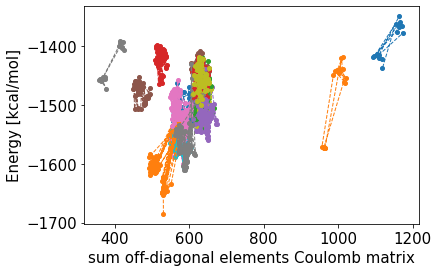

In [27]:
k = 19
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]
print('Silhouette score: ', scores_kmeans[index])

plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linewidth'] = 1

plt.figure()
#plt.title('k-means clustering (%s clusters)' % (np.max(labels)+1))
for i in range(np.max(labels) + 1):
    plt.plot(sum_coulomb[labels == i], energies[labels == i], '.--', label=i)

#plt.xlabel('Molecule index in the dataset')
#plt.xlabel('sum of diagonal of Coulomb matrix')
plt.xlabel('sum off-diagonal elements Coulomb matrix')
plt.ylabel('Energy [kcal/mol]')
plt.show()

How many molecules in each cluster?

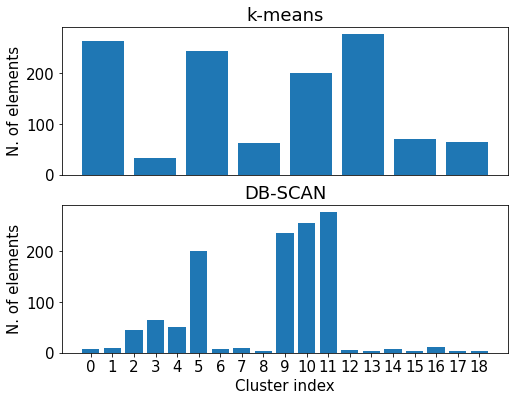

k-means:  [264, 34, 244, 62, 201, 278, 71, 65]
DB-SCAN:  [13, 7, 10, 45, 65, 50, 201, 7, 9, 3, 236, 255, 278, 5, 4, 8, 4, 12, 4, 3]


In [28]:
k = 8 # k-means
epsilon = 20 # DB-SCAN

plt.figure(figsize = (8,6))

# k-means clustering

index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

lengths_kmeans = []

for i_cluster in range(np.max(labels) + 1):
    lengths_kmeans.append(len(labels[labels == i_cluster]))

plt.subplot(2,1,1)
plt.bar(np.arange(np.max(labels)+1), lengths_kmeans, label='k-means', alpha=1)
#plt.legend()
plt.title('k-means')
plt.ylabel('N. of elements')
plt.xticks([])


# DB-SCAN clustering

index = np.where(epss == epsilon)[0][0]
labels = labels_DBSCAN[index]

lengths_DBscan = []
for i_cluster in range(-1, np.max(labels) + 1):
    lengths_DBscan.append(len(labels[labels == i_cluster]))

plt.subplot(2,1,2)
plt.bar(np.arange(np.max(labels) + 1), np.array(lengths_DBscan[1:]), label='DB-SCAN', alpha=1)
#plt.legend()
plt.title('DB-SCAN')
plt.xlabel('Cluster index')
plt.ylabel('N. of elements')
plt.xticks(np.arange(np.max(labels) + 1))
plt.show()

print('k-means: ',lengths_kmeans)
print('DB-SCAN: ',lengths_DBscan)


The n. of clusters selected by DBscan is 19, however only few of them do really contribute, while other ones contain significantly less molecules

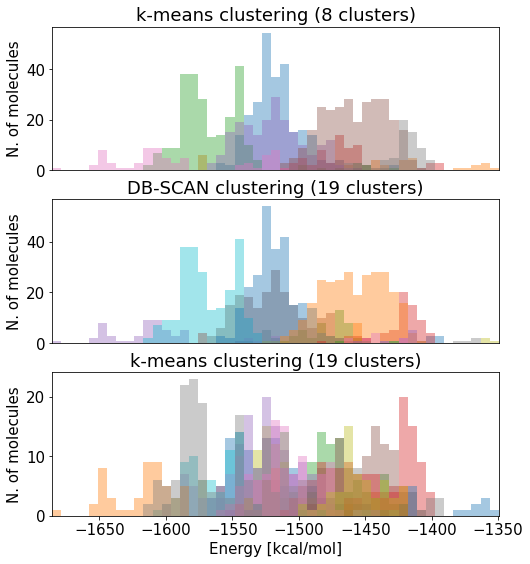

In [29]:
bins = np.linspace(np.min(energies), np.max(energies), 50)

k = 8
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

plt.figure(figsize=(8,9))

plt.subplot(3, 1, 1)
plt.title('k-means clustering (%s clusters)' % (np.max(labels) + 1))
for i in range(np.max(labels) + 1):
    plt.hist(energies[labels == i], alpha=0.4, bins=bins)  # ,density=True)
    plt.xlim([np.min(energies), np.max(energies)])
    #plt.xlabel('energy')
    plt.xticks([])
    plt.ylabel('N. of molecules')

epsilon = 20
index = np.where(epss == epsilon)[0][0]
labels = labels_DBSCAN[index]

plt.subplot(3, 1, 2)
plt.title('DB-SCAN clustering (%s clusters)' % (np.max(labels) + 1))
for i in range(np.max(labels) + 1):
    plt.hist(energies[labels == i], alpha=0.4, bins=bins)  # ,density=True)
    plt.xlim([np.min(energies), np.max(energies)])
    #plt.xlabel('Energy [kcal/mol]')
    plt.xticks([])
    plt.ylabel('N. of molecules')

k = 19
index = np.where(ks_kmeans == k)[0][0]
labels = labels_kmeans[index]

plt.subplot(3,1,3)
plt.title('k-means clustering (%s clusters)' % (np.max(labels) + 1))
for i in range(np.max(labels) + 1):
    plt.hist(energies[labels == i], alpha=0.4, bins=bins)  # ,density=True)
    plt.xlim([np.min(energies), np.max(energies)])
    plt.xlabel('Energy [kcal/mol]')
    plt.ylabel('N. of molecules')

plt.show()

Both the two methods have been able to cluster the set of molecules in such a way to separate different energy ranges, with quite similar results